In [35]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cmocean
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from src.load_SAIdata import Cases
%matplotlib inline

In [37]:
Cases('hres.ref.5')

directory does not exist: /projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.005/OUTPUT


hres.ref.5 -- b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.005
directory: /projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.005/OUTPUT
atm: []
ocn: []
lnd: []
ice: []
strataero: []
volcaero: []

In [48]:
ds = xr.open_dataset("../../../data/SST.nc")

# add cyclical point
ds = xr.concat((ds, ds.isel(nlon=0)), dim='nlon') 

# invalid points
mask = (ds.ULONG==-1) & (ds.ULAT==-1)

In [50]:
# remove sudden 360 deg jumps in longitude
ds.ULONG.data += 360 * ((ds.ULONG<0) & (ds.nlon>2500) & ~mask)
assert (abs(ds.ULONG.diff('nlon')) > 359).sum() == 0, "sudden jumps found in longitude"

Text(0.5, 0.98, 'fix longitudes')

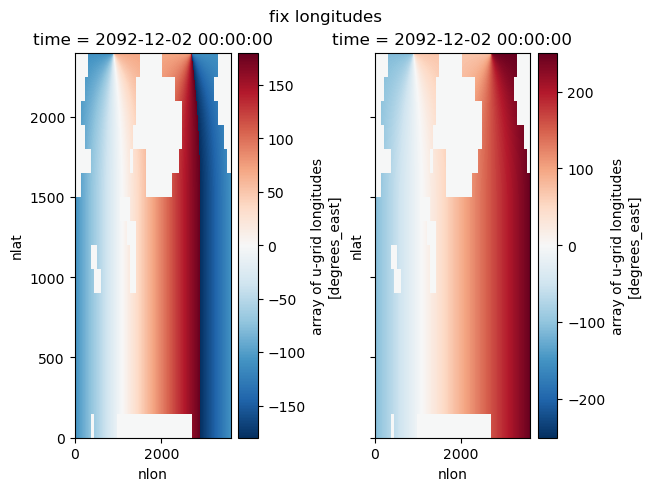

In [13]:
# remove sudden 360 deg jumps in longitude

fig,axs = plt.subplots(1,2, sharey=True, sharex=True, layout='constrained')
ds.ULONG.plot(ax=axs[0]); ax.set_title('before')
ds.ULONG.diff('nlon')
ds.ULONG.data += 360 * ((ds.ULONG<0) & (ds.nlon>2500) & ~mask)
ds.ULONG.plot(ax=axs[1]); ax.set_title('after')
fig.suptitle('fix longitudes')

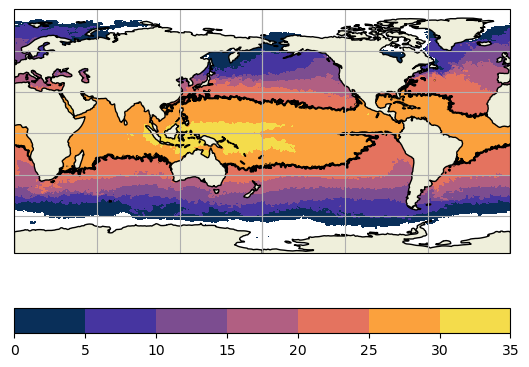

In [8]:
lons = ds.ULONG
lats = ds.ULAT
SST = ds.SST.where(~mask)

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

pcm = ax.contourf(lons, lats, SST, levels=range(0,36,5), transform=ccrs.PlateCarree(), cmap='cmo.thermal')
ax.contour(lons, lats, SST, levels=[25], transform=ccrs.PlateCarree(central_longitude=0), cmap='binary_r')
ax.add_feature(cfeature.LAND, zorder=2, edgecolor='black')

ax.gridlines()
fig.colorbar(pcm, orientation='horizontal')

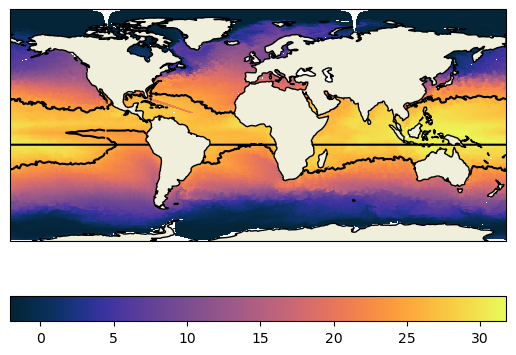

In [61]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
dsi = xr.concat((dsi, dsi.isel(nlon=0)), dim='nlon')
dsi = ds.isel(nlat=slice(None,None,10),nlon=slice(None,None,10))
#dsi = ds
SST = dsi.TEMP.isel(z_t=0, time=0)
mask = dsi.REGION_MASK > 0
pcm = ax.pcolormesh(SST.TLONG, SST.TLAT, SST.where(mask), transform=ccrs.PlateCarree(), cmap='cmo.thermal')
ax.contour(SST.TLONG%360, SST.TLAT.where(mask), SST.where(mask), levels=[25], transform=ccrs.PlateCarree(), cmap='binary_r')
ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black')
fig.colorbar(pcm, orientation='horizontal')